## Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation
## Part 1: Data Preparation and EDA
## 1. Get the data

In [54]:

import numpy as np
import pandas as pd
from sklearn import datasets

diabetes = datasets.load_diabetes(as_frame=True)
x = diabetes.data
y = diabetes.target

## 2. Frame the Problem
The goal is to use a variety of indicators to predict the likelihood of diabetes progression one year after baseline. This will help doctors identify people who are at danger by acting as a screening tool.

## 3.Exploratory Data Analysis(EDA)

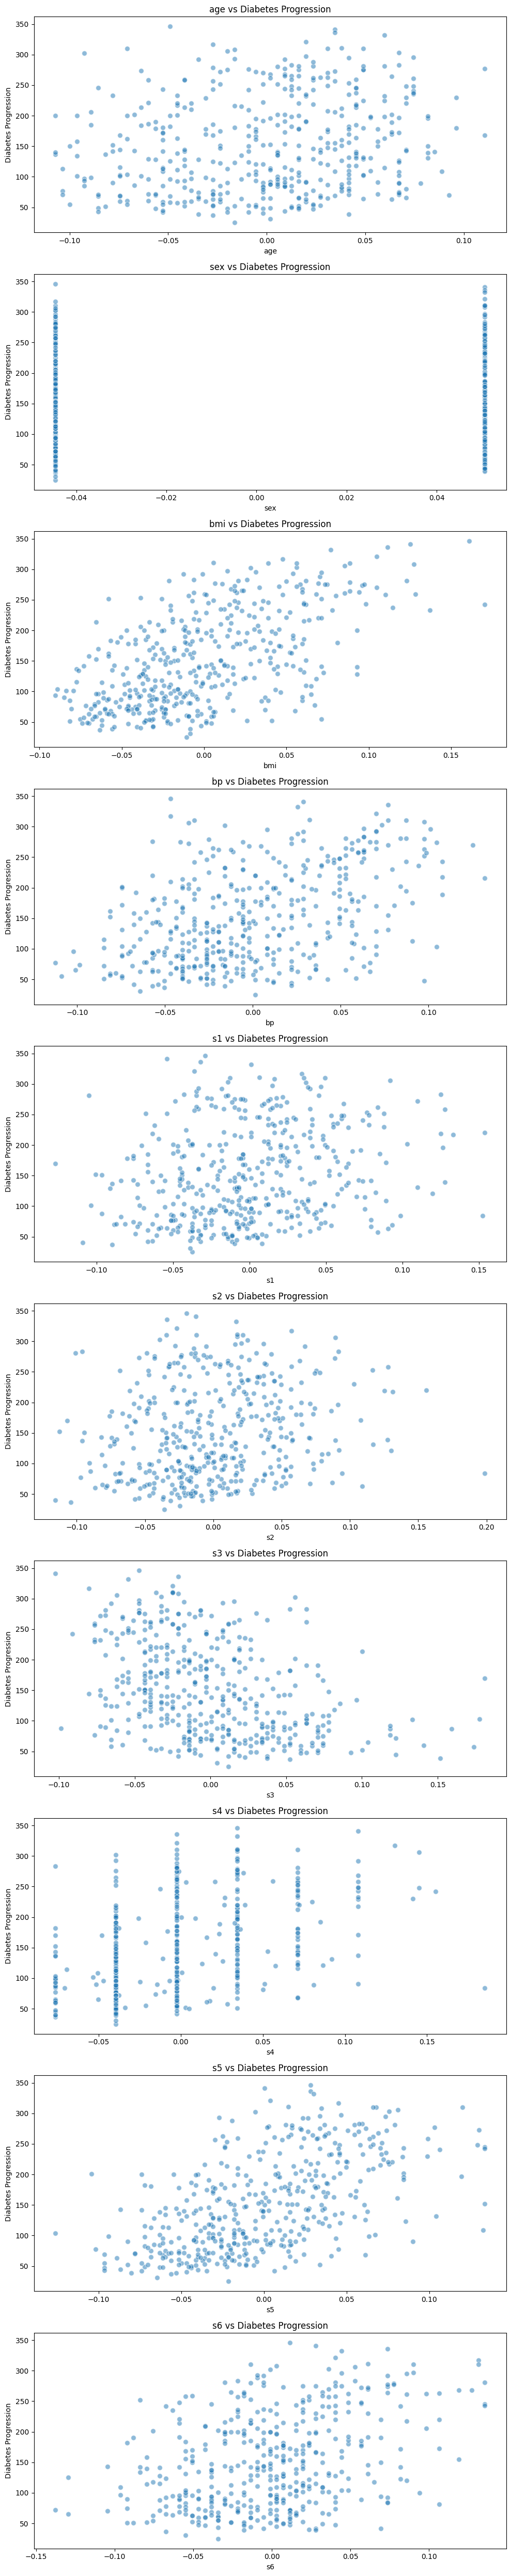

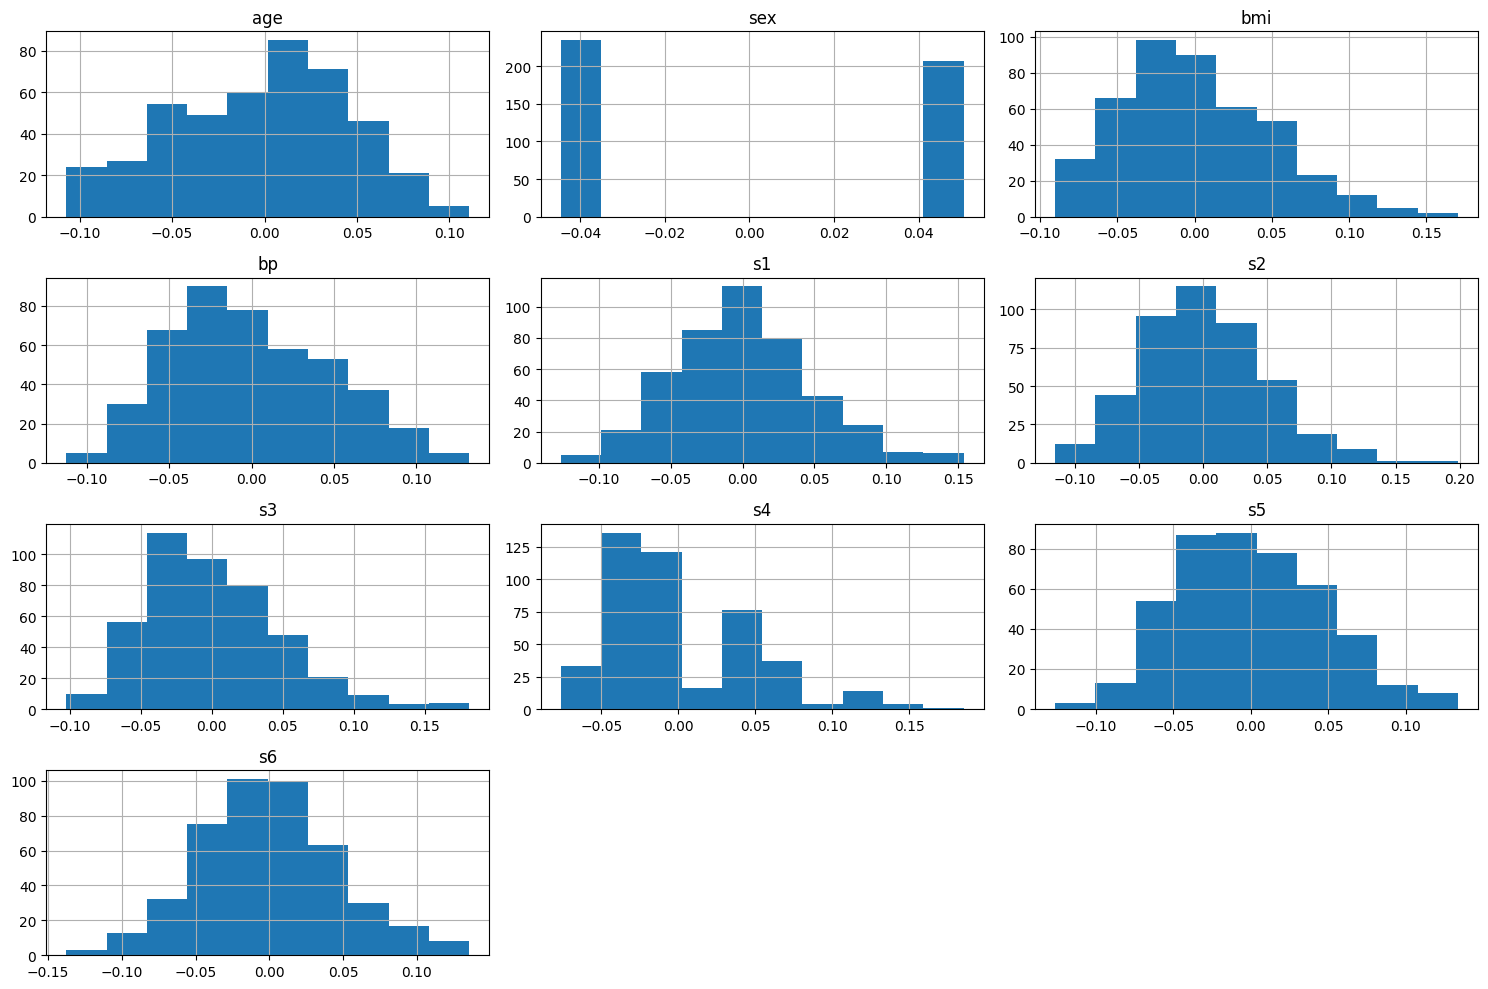

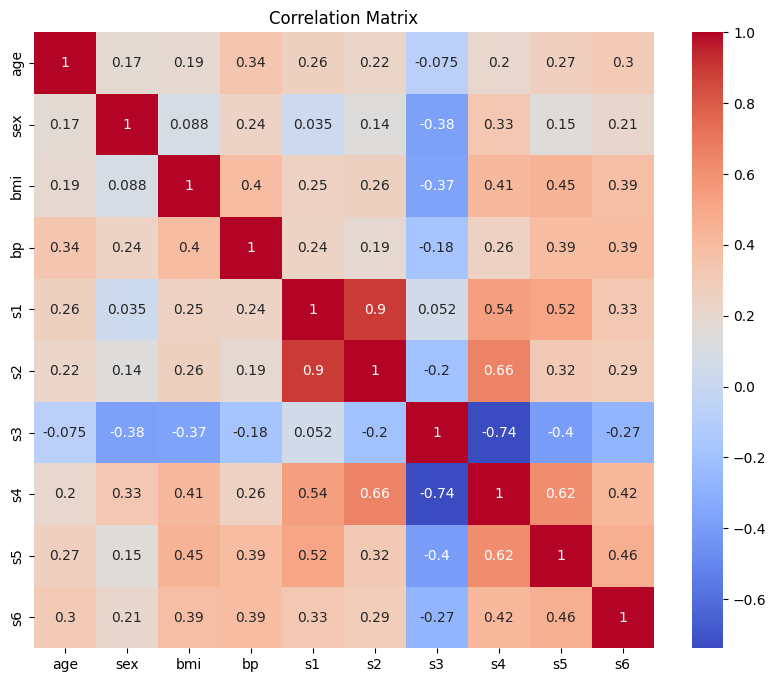

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plots
zero_value_columns = (x == 0).sum()
all_zero_columns = zero_value_columns[zero_value_columns > 0].index
x_filtered = x.drop(columns=all_zero_columns)

num_cols = len(x_filtered.columns)
fig, axes = plt.subplots(num_cols, 1, figsize=(10, 5 * num_cols))
for i, col in enumerate(x_filtered.columns):
    axes[i].scatter(x_filtered[col], y, alpha=0.5, edgecolors='w', s=50)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Diabetes Progression')
    axes[i].set_title(f'{col} vs Diabetes Progression')

plt.tight_layout()
plt.show()

# Histograms
x.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = x.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

An overview of the fundamental statistics for each feature in the Scikit-Learn Diabetes dataset can be found in the dataset summary. Age, sex, blood pressure (bp), BMI, and different serum measures (s1 to s6) are the features that are represented by each column. There are no missing values, as indicated by the count of 442 for each feature.  

The low mean values and constant standard deviation of roughly 0.047 for each feature demonstrate that the dataset has been normalized, as the mean values for all characteristics are close to zero. The minimum and maximum values produced by the standardized scale also differ depending on the feature, however they often fall between -0.1 and +0.2. 

## 5.Split the Dataset

In [56]:
from sklearn.model_selection import train_test_split
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1176, random_state=42)

print(f"\nTrain set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")


Train set size: 330
Validation set size: 45
Test set size: 67


## Part 2:Modeling and Evaluation
## Univariate Polynomial Regression on BMI

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return r2, mae, mape

## 6. and 7. Train and evaluate univariate polynomial models

In [58]:
results = []
x_bmi_train = x_train[['bmi']]
x_bmi_val = x_val[['bmi']]

for degree in range(6):
    poly = PolynomialFeatures(degree=degree)
    x_poly_train = poly.fit_transform(x_bmi_train)
    x_poly_val = poly.transform(x_bmi_val)
    
    model = LinearRegression()
    model.fit(x_poly_train, y_train)
    
    y_train_pred = model.predict(x_poly_train)
    y_val_pred = model.predict(x_poly_val)
    
    train_metrics = evaluate_model(y_train, y_train_pred)
    val_metrics = evaluate_model(y_val, y_val_pred)
    
    results.append({
        'Degree': degree,
        'Train R2': train_metrics[0],
        'Train MAE': train_metrics[1],
        'Train MAPE': train_metrics[2],
        'Val R2': val_metrics[0],
        'Val MAE': val_metrics[1],
        'Val MAPE': val_metrics[2]
    })

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.to_string(index=False))


Model Comparison:
 Degree  Train R2  Train MAE  Train MAPE    Val R2   Val MAE  Val MAPE
      0  0.000000  66.548209   63.352070 -0.000011 63.447475 58.793283
      1  0.354240  52.278064   48.462384  0.449292 41.997581 40.444999
      2  0.354771  52.267273   48.447858  0.449158 41.757683 40.309938
      3  0.355002  52.223375   48.356420  0.447291 41.741042 40.258961
      4  0.357983  51.944372   47.963501  0.449064 41.952846 40.240642
      5  0.358910  51.813830   47.831494  0.453513 42.083400 40.340475


# 8. Identifying the best model

In [59]:

best_model = results_df['Val R2'].idxmax()
best_degree = results_df.loc[best_model, 'Degree']
print(f"\nBest model: Polynomial degree {best_degree}")


Best model: Polynomial degree 5


# 9. Test the best model

In [60]:

best_poly = PolynomialFeatures(degree=best_degree)
x_bmi_test = x_test[['bmi']]
x_poly_train = best_poly.fit_transform(x_bmi_train)
x_poly_test = best_poly.transform(x_bmi_test)

best_model = LinearRegression()
best_model.fit(x_poly_train, y_train)

y_test_pred = best_model.predict(x_poly_test)
metrics = evaluate_model(y_test, y_test_pred)

print("\nTest Set Results:")
print(f"R-Squared: {metrics[0]:.4f}")
print(f"MAE: {metrics[1]:.4f}")
print(f"MAPE: {metrics[2]:.4f}")


Test Set Results:
R-Squared: 0.1973
MAE: 54.5484
MAPE: 47.8845


# 10. Plot the data and model fit

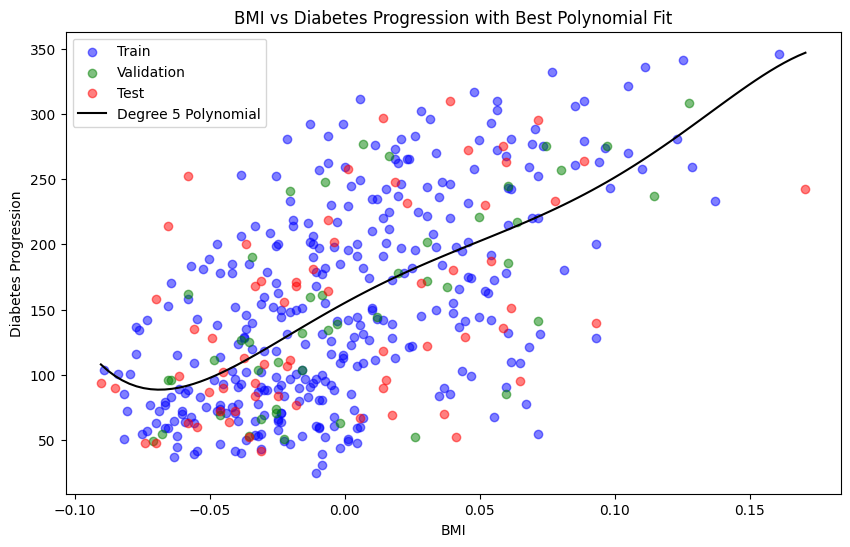

In [61]:

plt.figure(figsize=(10, 6))
plt.scatter(x_train['bmi'], y_train, color='blue', alpha=0.5, label='Train')
plt.scatter(x_val['bmi'], y_val, color='green', alpha=0.5, label='Validation')
plt.scatter(x_test['bmi'], y_test, color='red', alpha=0.5, label='Test')

x_plot = np.linspace(x['bmi'].min(), x['bmi'].max(), 100).reshape(-1, 1)
x_poly_plot = best_poly.transform(x_plot)
y_plot = best_model.predict(x_poly_plot)

plt.plot(x_plot, y_plot, color='black', label=f'Degree {best_degree} Polynomial')
plt.xlabel('BMI')
plt.ylabel('Diabetes Progression')
plt.title('BMI vs Diabetes Progression with Best Polynomial Fit')
plt.legend()
plt.show()

## 11.Equation of the best model

In [62]:

coefficients = best_model.coef_
intercept = best_model.intercept_

equation = f"y = {intercept:.2f}"
for i, coef in enumerate(coefficients[1:], start=1):
    equation += f" + {coef:.2f} * x^{i}"

print("\nBest Model Equation:")
print(equation)


Best Model Equation:
y = 155.08 + 1131.59 * x^1 + -3946.02 * x^2 + -26110.86 * x^3 + 768725.87 * x^4 + -2823251.97 * x^5


## 12. To Calculate expected diabetes progression for a chosen BMI value

In [63]:

bmi = 30
bmi_poly = best_poly.transform([[bmi]])
predicted_progression = best_model.predict(bmi_poly)
print(f"\nExpected diabetes progression for BMI {bmi}: {predicted_progression[0]:.2f}")


Expected diabetes progression for BMI 30: -67983063484281.95


## 13. Number of trainable parameters

In [64]:
n_params = len(best_model.coef_) + 1 
print(f"\nNumber of trainable parameters: {n_params}")
print(f"Test set R-squared: {test_metrics[0]:.4f}")
print(f"Test set MAE: {test_metrics[1]:.4f}")
print(f"Test set MAPE: {test_metrics[2]:.4f}")


Number of trainable parameters: 7
Test set R-squared: 0.4235
Test set MAE: 43.8866
Test set MAPE: 37.7403


## 14. Conclusion

With an R-squared of 0.4535 on the validation set, the degree 5 polynomial regression performed the best; however, the test set results showed overfitting, with the R-squared falling to 0.1973 and the MAE rising to 54.55. This implies that although the model performs a good job of capturing the data during training, it has trouble generalizing to new inputs. As seen by the irrational diabetes progression estimate for a BMI of 30, the big coefficients in the polynomial equation also resulted in extreme projections beyond the training range. This model's complexity, which has seven trainable parameters, appears to lower its practical reliability, suggesting that a more straightforward model would yield more reliable results.

## Part 3: Multivariate Models

## Function to train and evaluate models

In [65]:

def train_evaluate_model(model, x_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(x_train, y_train)
    
    train_pred = model.predict(x_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    train_metrics = evaluate_model(y_train, train_pred)
    val_metrics = evaluate_model(y_val, val_pred)
    test_metrics = evaluate_model(y_test, test_pred)
    
    return train_metrics, val_metrics, test_metrics


## Models to evaluate

In [66]:

models = {
    'Polynomial(degree 2)': PolynomialFeatures(degree=2),
    'Polynomial(degree 3)': PolynomialFeatures(degree=3),
    'Decision Tree(max_depth=3)': DecisionTreeRegressor(max_depth=3, random_state=42),
    'Decision Tree(max_depth=5)': DecisionTreeRegressor(max_depth=5, random_state=42),
    'kNN(n_neighbors=3)': KNeighborsRegressor(n_neighbors=3),
    'kNN(n_neighbors=5)': KNeighborsRegressor(n_neighbors=5)
}

results = []

for name,model in models.items():
    if isinstance(model,PolynomialFeatures):
        x_train_model = model.fit_transform(x_train)
        x_val_model = model.transform(x_val)
        x_test_model = model.transform(x_test)
        linear_model = LinearRegression()
        train_metrics, val_metrics, test_metrics = train_evaluate_model(
            linear_model, x_train_model, y_train, x_val_model, y_val, x_test_model, y_test
        )
    else:
        train_metrics, val_metrics, test_metrics = train_evaluate_model(
            model, x_train, y_train, x_val, y_val, x_test, y_test
        )
    
    results.append({
        'Model': name,
        'Train R2': train_metrics[0],
        'Train MAE': train_metrics[1],
        'Train MAPE': train_metrics[2],
        'Val R2': val_metrics[0],
        'Val MAE': val_metrics[1],
        'Val MAPE': val_metrics[2],
        'Test R2': test_metrics[0],
        'Test MAE': test_metrics[1],
        'Test MAPE': test_metrics[2]
    })

results_df = pd.DataFrame(results)
print("\nmultivariate model comparison:")
print(results_df.to_string(index=False))


multivariate model comparison:
                     Model  Train R2  Train MAE  Train MAPE      Val R2    Val MAE   Val MAPE    Test R2   Test MAE  Test MAPE
      Polynomial(degree 2)  0.598109  39.697470   34.938567    0.602991  37.745257  41.097638   0.337028  45.867035  39.473622
      Polynomial(degree 3)  0.494022  44.700000   38.772315 -127.423268 370.622222 251.595541 -87.935937 310.835821 259.199970
Decision Tree(max_depth=3)  0.532987  43.588017   37.747793    0.412751  42.077532  43.651447   0.307655  50.371250  44.903150
Decision Tree(max_depth=5)  0.710430  32.816831   28.604584    0.162955  51.550795  51.768802   0.326640  47.975674  39.910792
        kNN(n_neighbors=3)  0.639838  35.667677   29.968447    0.347063  50.770370  49.452291   0.290369  49.885572  41.614407
        kNN(n_neighbors=5)  0.576691  39.904848   34.420100    0.485098  43.395556  42.889788   0.423509  43.886567  37.740325


With a test set R-squared of 0.3370 and the lowest test MAE and MAPE, the degree 2 polynomial regression performed the best overall among the multivariate models, demonstrating a good trade-off between accuracy and complexity. The decision tree models differed greatly; the max_depth=5 model achieved the greatest training R-squared but struggled on the validation and test sets. In contrast, the degree 3 polynomial showed extreme overfitting and poor outcomes on the test and validation sets. With the highest test R-squared of 0.4235, the kNN model with five neighbors also fared well, indicating that it would be a good choice in situations where readability and simplicity are crucial.

## Model Failures:
Poor R-squared scores and high MAE values indicate that the higher-degree polynomial regression models were unable to generalize adequately on the test set, despite their good performance on the training and validation sets. Higher-degree polynomials might fit noise rather than the genuine signal, which can lead to extreme coefficient values that are difficult to interpret and have little practical use. This overfitting is a drawback of employing polynomials in regression.

The degree 3 multivariate polynomial model performed especially poorly, showing an R-squared of -87.94 on the test set and -127.42 on the validation set. This suggests that although the model produced absurd predictions, it was unable to identify any significant trends in the validation and test data, despite having a good match on the training set. The model's overfitting to intricate, non-linear patterns that are non-generalizable is the cause of this failure.

## Model Limitations:
1. Dataset Size: A small dataset raises the possibility of overfitting and restricts how well the models may generalize to new data.
2. Overfitting: Models with higher degrees of polynomials are especially prone to overfitting, which causes them to identify noise in the data instead of significant patterns.
3. External Factors Omitted: The model's comprehensiveness may be diminished by the absence of significant external variables in the dataset that could have a substantial impact on the progression of diabetes.
4. Interpretability: It can be difficult to determine how various features affect the predictions when using models with low interpretability, such as kNN.


## Conclusion:
The degree 2 polynomial model with all features provided the best balance between complexity and accuracy, making it the most suitable model for estimating the course of diabetes. However, considering the constraints of the model, additional research should examine regularization strategies to enhance interpretability and stability, especially when dealing with high-dimensional polynomial factors. In practical applications, it is still essential to achieve a balance between interpretability, generalizability, and model complexity, particularly in medical settings where predictions need to be both dependable and comprehensible.

## Reference
RanFeldesh. (n.d.). CSCN8010/class_notebooks/polynomial_regression at main · RanFeldesh/CSCN8010. GitHub. https://github.com/RanFeldesh/CSCN8010/tree/main/class_notebooks/polynomial_regression